In [1]:
import pandas as pd
import os
import datetime
import numpy as np
import sys
import seaborn as sns

sys.path.insert(0, '../scripts')
import EOL_tools
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm

## Read data

In [2]:
phage_metadata = '../data/_raw/phage_metadata.tsv'
exp_metadata = '../data/_raw/experiment_metadata.tsv'

In [3]:
# read experiment metadata
exp_metadata = pd.read_csv(exp_metadata, sep='\t')

In [4]:
# append all the experiments into single dataframe
dire = '../data/_raw'

experiments = []

for column, row in exp_metadata.iterrows():
    
    experiment_name = row['file']
    
    # get full file name with path
    file = os.path.join(dire, f'{experiment_name}.tsv')
    
    # read experiment and clean up
    df_exp = EOL_tools.read_experiment(file, row['strain'], row['plate'], phage_metadata)
    
    # add column with experiment name
    df_exp['experiment'] = [experiment_name] * len(df_exp)
    
    experiments.append(df_exp)

df_all_experiments = pd.concat(experiments)

## Plot

In [5]:
strains = ['sen', 'ppu', 'sma', '-']
phages = ['PRD1', 'amb', 'cer', '-']
strains = ['sen', 'sma', 'ppu', '-']
phages = ['cer', 'PRD1', '-']

strain_order = dict(zip(strains, range(0, len(strains))))
phage_order = dict(zip(phages, range(0, len(phages))))

## Plot heatmap

In [6]:
df_las = pd.read_csv('../data/all_liquidasssayscores.tsv', sep='\t')

df_las = df_las[df_las['strain'].isin(strains)]
df_las = df_las[df_las['phage'].isin(phages)]

In [7]:
# color palettes
greenish = sns.cubehelix_palette(start=2.8, rot=-.2, dark=0, light=.97, as_cmap=True)
blueish = sns.cubehelix_palette(start=2.9, rot=-.16, dark=0, light=.97, as_cmap=True)
new = sns.cubehelix_palette(start=3, rot=.5, gamma=1, hue=1, dark=0.1, light=.97, as_cmap=True)

background = '#ededf2'

In [8]:
# remove no phage rows and make into heatmap-style matrix
df_las_heatmap = df_las[df_las['phage'] != '-'].pivot(index='strain', columns='phage', values='las')

# ground everything at zero
df_las_heatmap[df_las_heatmap <= 0] = 0

In [9]:
# reorder
df_fig = df_las_heatmap[phages[:-1]]
df_fig = df_fig.reindex(strains[:-1])

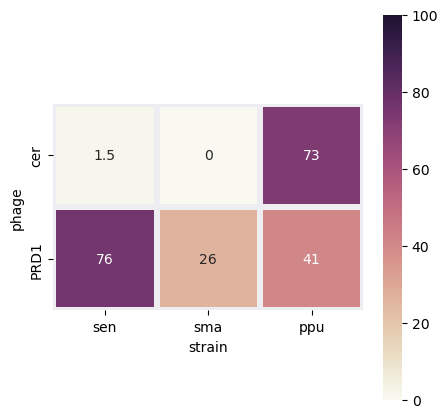

In [10]:
fig, axs = plt.subplots(1, 1,
                        figsize=(5,5))

g = sns.heatmap(df_fig.T,
                ax=axs,
                square=True,
                linewidths=3,
                linecolor=background,
                cmap=new,
                cbar=True,
                vmax=100,
                annot=True)

g.set_facecolor(background)

# horizontal lines
#for i in range(df_fig.shape[1]+1):
 #   g.axhline(i, color='white', lw=2)

#plt.savefig('../data/svgs/mini_hm.svg')
plt.show()

## Plot curves

In [11]:
def subsample(df_exp, subsample_freq='30min'):
    '''
    subsample time series
    '''
    df_sub = df_exp.copy()    
    
    # fill no phage wells with '-'
    df_sub['phage'] = df_sub['phage'].fillna('-')
    
    # subsample
    df_sub.set_index(['well', 'timedelta', 'phage'], inplace=True)
    df_sub = df_sub.groupby([pd.Grouper(level='well'),
                             pd.Grouper(level='phage'),
                             pd.Grouper(level='timedelta', freq=subsample_freq)])['OD600'].mean().reset_index()
    
    # convert timedelta into float minutes
    df_sub['minutes'] = df_sub['timedelta'].dt.total_seconds()/60
    
    return df_sub

In [12]:
# subsample
df_all_experiments = df_all_experiments[df_all_experiments['strain'].isin(strains)]
df_all_experiments = df_all_experiments[df_all_experiments['phage'].isin(phages)]

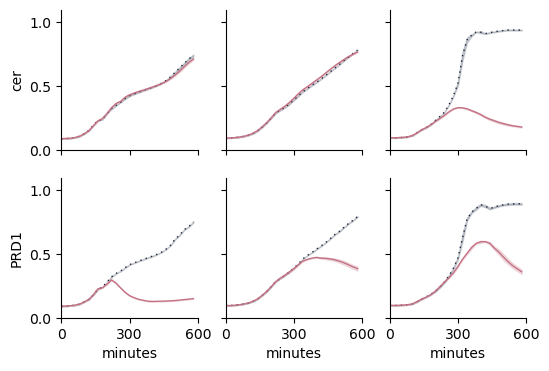

In [15]:
fig, axs = plt.subplots(2, 3,
                        figsize=(6,4),
                        sharex=True,
                        sharey=True)

sns. despine()

# iterate over each experiment
for experiment in df_all_experiments['experiment'].unique():
    
    # get dataframe with that experiment
    df_experiment = df_all_experiments[df_all_experiments['experiment'] == experiment]
    
    # extract which strain is being run in that experiment
    strain_exp = df_experiment['strain'].unique()[0]
    
    # subsample dataframe 
    df_sub = subsample(df_experiment, subsample_freq='20min')
    
    # get column to use per strain depending on dictionary
    col = strain_order[strain_exp]
    
    axs[0][0].set_xlim([0, 601])
    axs[0][0].set_ylim([0, 1.1])
    axs[0][0].yaxis.set_ticks(np.arange(0, 1.5, .5))
    axs[0][0].xaxis.set_ticks(np.arange(0, 800, 300))
    # iterate over phage per strain
    for phage in df_experiment['phage'].unique():
        # if phage is not phage negative control
        if phage != '-':
            # define row to plot phage
            row = phage_order[phage]
            
            # titles only in first column and last row
            axs[row][col].set_xlabel('')
            if col == 0:
                axs[row][col].set_ylabel(phage)
            if row == 2:
                axs[row][col].set_xlabel(strain_exp)
            
            
            
            # plot no phage control for each experiment
            sns.lineplot(data=df_sub[df_sub['phage'] == '-'],
                         ax=axs[row][col],
                         x='minutes',
                         y='OD600',
                         color='#1B263C',
                         errorbar='se',
                         style=True,
                         lw=1,
                         dashes=[(1, 3)],
                         legend=None)
            
            # plot phage positive for each experiment
            sns.lineplot(data=df_sub[df_sub['phage'] == phage],
                         ax=axs[row][col],
                         x='minutes',
                         y='OD600',
                         errorbar='se',
                         lw=1,
                         color='#C37082')
            
#plt.savefig('../data/svgs/mini_curves.svg')
plt.show()